In [133]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.path as mpath
import xarray as xr
import cartopy.crs as ccrs
import scipy.stats as stats

In [134]:
# load netcdf data
fn='./air.mon.mean.nc'
ds=xr.open_dataset(fn)
# select time range
TMP=ds.air.sel(time=slice("1948-01-01","2020-12-31"))
TMP

<xarray.DataArray 'air' (time: 876, lat: 73, lon: 144)>
[9208512 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Attributes:
    long_name:     Monthly Mean Air Temperature at sigma level 0.995
    valid_range:   [-2000.  2000.]
    units:         degC
    precision:     1
    var_desc:      Air Temperature
    level_desc:    Surface
    statistic:     Mean
    parent_stat:   Individual Obs
    dataset:       NCEP Reanalysis Derived Products
    actual_range:  [-73.78001  42.14595]

In [135]:
#get data for August
mon = 8
TMP_AUG = TMP.sel(time = TMP['time.month']==mon)
year_val=TMP_AUG['time.year'].values

#get dimension
da = TMP_AUG
nlat = da.lat.size
nlon = da.lon.size



In [136]:
# data loading
# Nino3.4 index downloaded from:
# https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni

# df=pd.read_csv('./nino34_1870_2020.txt', delim_whitespace=True, header=None)
# alternatively, you could use the following command to read the whitespece separated data file
# df=pd.read_csv('./nino34_1870_2020.txt', delimiter=r"\s+", header=None)

df=pd.read_csv('./nino34_1870_2020.txt', delimiter="\t", header=None)

# replace invalid values with NaN 
df=df.replace(-99.99,np.nan)
print(df)
# convert dataframe to numpy matrix
data=df.values

year=data[:,0]
nino34=data[:,1:]

tr=(1948,2021)

tind=((year>=tr[0])&(year<tr[1]))

year_sel=year[tind]
nino34_sel=nino34[tind,:]

(ny,nm)=np.shape(nino34_sel)

       0      1      2      3      4      5      6      7      8      9   \
0    1870  25.58  25.57  26.43  26.96  26.59  26.61  26.19  25.99  26.22   
1    1871  26.33  26.18  26.83  27.27  27.16  27.16  26.62  26.54  26.51   
2    1872  25.86  26.14  26.76  27.00  27.25  27.16  26.91  26.02  25.73   
3    1873  25.79  25.75  25.95  27.10  27.33  27.21  26.65  26.48  26.41   
4    1874  25.64  25.70  25.85  26.83  27.00  26.96  26.22  25.82  25.62   
..    ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
147  2017  26.24  26.75  27.17  27.99  28.17  27.91  27.44  26.69  26.20   
148  2018  25.72  26.03  26.53  27.41  27.75  27.81  27.49  26.93  27.05   
149  2019  27.09  27.38  28.06  28.44  28.48  28.34  27.64  27.07  26.86   
150  2020  27.22  27.25  27.62  28.26  27.74  27.48  27.18  26.46  26.09   
151  2021  25.54  25.82  26.54  27.22  27.45  27.63  27.03    NaN    NaN   

        10     11     12  
0    25.82  25.86  25.79  
1    26.40  26.35  26.01  
2    2

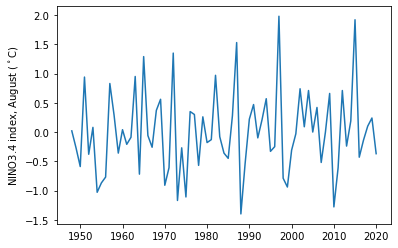

In [137]:
# get August nino34 SST
nino34_AUG=nino34_sel[:,7]
# get nino34 SST anomaly (i.e., nino3.4 index)
nino34_ano_AUG=nino34_AUG-np.mean(nino34_AUG)

x=year_sel
y=nino34_ano_AUG

fig=plt.figure()
plt.plot(x,y)
plt.ylabel('NINO3.4 index, August ($^\circ$C)')
plt.show()
print()

In [130]:
# calculate anomalies for NCEP data
#TMP_mean = TMP.groupby("time.month").mean("time")
#TMP_mean
# Here we are using the broadcasting feature of xarray
#TMP_anomaly = TMP.groupby("time.month") - TMP_mean
#TMP_anomaly

In [131]:
#da=TMP_anomaly
#nlon=da.lon.size
#nlat=da.lat.size

In [138]:
np.size(TMP_AUG.isel(lat=jj, lon=ii).values)

73

In [139]:
# define a function in python
def regrcorr3(X,Y,CL):
    C=np.cov(X,Y)
    # slope
    a=np.empty(2)
    a[0]=C[0,1]/C[0,0]
    # intercept
    a[1]=np.mean(Y)-a[0]*np.mean(X)
    # correlation coefficient
    r=C[0,1]/np.sqrt(C[0,0]*C[1,1])    
    # sample size
    N=np.size(Y)    
    # lag-1 autocorrelation for Y
    y0=Y[0:-1]
    y1=Y[1:]
    Cy=np.cov(y0,y1)
    r1=Cy[0,1]/np.sqrt(Cy[0,0]*Cy[1,1])
    # effective sample size
    Neff=N*(1-r1)/(1+r1)
    Neff=min(N,Neff)
    
    # calculate tcrit (two-tailed)
    tcrit=stats.t.ppf((1+CL)/2,Neff-2)
    
     # SE of regression
    Y_pred=a[0]*X+a[1]
    err2=sum(np.square(Y-Y_pred))/(Neff-2)
    SE2=err2/sum(np.square(X-np.mean(X)))
    SE=np.sqrt(SE2)
    CI_slope = tcrit*SE
    
    #SE of correlation coefficient
    SE_r = np.sqrt((1-r**2)/(Neff-2))
    
    CI_r=tcrit*SE
    
    return a,r,CI_slope,CI_r 

In [142]:
# calculate correlation coefficient
r_mat=np.empty((nlat,nlon))
slope=np.empty((nlat,nlon))

r_CI = np.empty((nlat,nlon))
slope_CI = np.empty((nlat,nlon))
#r_mat[:]=np.nan
y=nino34_ano_AUG

# CL
CL=0.95

for ii in np.arange(0,nlon):
    print(ii)
    for jj in np.arange(0,nlat):
        x=TMP_AUG.isel(lat=jj,lon=ii).values
        a,r,CI_slope,CI_r=regrcorr3(x,y,CL)
#         r=np.corrcoef(x,y)
        r_mat[jj,ii]=r
        slope[jj,ii]=a[0]
        r_CI[jj,ii] = CI_r
        slope_CI[jj,ii]=CI_slope

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143


In [143]:
# if significant, trdsig = 1, otherwise, trdsig = 0
trdsig = np.zeros((nlat,nlon))
trdsig[slope_CI<np.abs(slope)]=1

rsig = np.zeros((nlat,nlon))
rsig[r_CI <np.abs(r_mat)] =1              


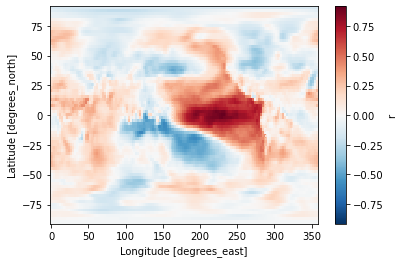

In [146]:
# re-assemble the data array and save it as netcdf
da=xr.DataArray(data=r_mat,dims=['lat','lon'],coords=dict(lat=TMP_anomaly.lat,lon=TMP_anomaly.lon),name='r')

# save the data to netcdf
ds_out=da.to_dataset()
ds_out.to_netcdf('./ncep_nino34_r.nc')

# make a simple plot
da.plot()
plt.show()

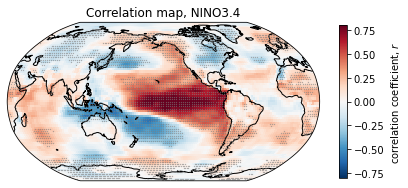

In [151]:
ind_r = (rsig==1)

X=da.lon.values
Y=da.lat.values
Z=da.values

# grid boundaries
Xb=np.arange(-2.5/2, 360,2.5)
Yb=np.arange(90-2.5/2, -90,-2.5)
Yb=np.append(90,Yb)
Yb=np.append(Yb,-90)


fig=plt.figure(figsize=(7, 4))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-150))
ax.coastlines()
cf=plt.pcolormesh(Xb,Yb,Z, transform=ccrs.PlateCarree(),cmap='RdBu_r',vmin=-0.8,vmax=0.8,rasterized=True)
fig.colorbar(cf, ax=ax,shrink=0.7, label='correlation coefficient, $\itr$')

plt.plot(X_mat[ind_r],Y_mat[ind_r], '.' , color='gray', markersize = 0.5, transform = ccrs.PlateCarree())

ax.set_title('Correlation map, NINO3.4')

fn='Fig_ncep_nino34_correlation_plot'
plt.savefig('./fig/'+fn+'.pdf',bbox_inches="tight",dpi=300)
plt.savefig('./fig/'+fn+'.png',bbox_inches="tight",dpi=300)
plt.show()

